In [127]:
import pandas as pd
import numpy as np 
from pymongo import MongoClient
import sys, os, datetime, time, json

# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the directory containing the module
module_dir = os.path.abspath(os.path.join(current_dir, "../config"))

# Add the directory to sys.path
sys.path.append(module_dir)

from data_pipeline_config import load_pipeline_config
from mongdb_config import load_mongo_config

## Stock Picking Rationale

- **Data Collection**:
  - Fetches stock alert data from a MongoDB collection based on a specified start date.
  - Converts the fetched data into a pandas DataFrame for analysis.

- **Interval Weighting**:
  - Assigns weights to different intervals (e.g., 1-day, 5-day) based on their length, with longer intervals receiving higher weights.
  
- **Stock Evaluation**:
  - Evaluates stocks by applying interval-based weights to different alert types (e.g., `169ema_recovery`, `13ema_recover_failed`).
  - Summarizes the weighted values for each stock based on alert occurrences and interval weights.

- **Sorting Stocks**:
  - Sorts stocks by their weighted recovery and velocity alerts, prioritizing stocks with positive recovery signals and de-prioritizing those with negative or failure signals.

- **Stock Candidates Selection**:
  - Selects the top stock candidates for each day based on their weighted alert values, prioritizing stocks with stronger recovery alerts.
  
- **Sandbox and Real-Time Modes**:
  - In **sandbox mode**, processes stock data for multiple historical dates.
  - In **real-time mode**, selects stock candidates for a specific date, such as the current day.

- **Return Output**:
  - Outputs the stock candidates for each date in a DataFrame for further analysis or integration into trading strategies.

In [165]:
class pick_stock:
    def __init__(self, alert_collection, start_date, sandbox_mode=False):
        self.alert_collection = alert_collection
        
        # Fetch the data, sorted by symbol and date
        self.start_date = start_date
        self.data = self.get_stock_dataframe()
        self.distinct_intervals = self.data['interval'].unique()
        # Dictionary to store stock candidates
        self.stock_candidates = {}

        # Define weights for intervals (e.g., larger intervals get more weight)
        self.interval_weights = {interval: weight for weight, interval in enumerate(self.distinct_intervals, start=1)}

        self.sandbox_mode = sandbox_mode
    def get_stock_dataframe(self):
        # Fetch the data from MongoDB and convert to DataFrame
        data = self.alert_collection.find({'date': {'$gte': pd.to_datetime(self.start_date)}}, {'_id': 0})
        df = pd.DataFrame(list(data))
        return df
    
    def evaluate_stocks(self, data):
        # Group by symbol and apply interval-based weighting for velocity alerts
        velocity_summary = data.copy()
        
        # Map interval weights
        velocity_summary['interval_weight'] = velocity_summary['interval'].map(self.interval_weights)
        
        # Calculate weighted values for each alert type
        alert_types = ['169ema_recovery', '169ema_recover_failed', '13ema_recovery', '13ema_recover_failed', 'velocity_loss', 'velocity_maintained']
        for alert in alert_types:
            velocity_summary[f'weighted_{alert}'] = (velocity_summary['velocity_alert'] == alert) * velocity_summary['interval_weight']
        
        # Group by symbol and sum the weighted values
        weighted_columns = [f'weighted_{alert}' for alert in alert_types]
        velocity_summary = velocity_summary.groupby('symbol')[weighted_columns].sum().reset_index()
        
        # Sort stocks by weighted values
        sort_order = ['weighted_169ema_recovery', 'weighted_13ema_recovery', 'weighted_velocity_maintained', 
                'weighted_13ema_recover_failed', 'weighted_169ema_recover_failed', 'weighted_velocity_loss']
        velocity_summary = velocity_summary.sort_values(by=sort_order, ascending=[False, False, False, True, True, True])
        
        velocity_summary = velocity_summary[(velocity_summary['weighted_169ema_recovery'] > 0) | 
                                            (velocity_summary['weighted_velocity_maintained'] >= 11)]
        return velocity_summary
    
    def run(self):
        # Loop through each unique date
        if self.sandbox_mode:
            for date in self.data['date'].unique():
                today_data = self.data[self.data['date'] == date]
                today_data_eval = self.evaluate_stocks(today_data)
                
                # Symbol of the day
                symbol_of_the_day = today_data_eval['symbol'].tolist()[:5]
                self.stock_candidates[date] = symbol_of_the_day
        else:
            today_data = self.data[self.data['date'] == pd.to_datetime('2023-01-01')]
            today_data_eval = self.evaluate_stocks(today_data)
            
            # Symbol of the day
            symbol_of_the_day = today_data_eval['symbol'].tolist()[:5]
            self.stock_candidates[pd.to_datetime('2023-01-01')] = symbol_of_the_day
            
            
        # Return the stock candidates
        return pd.DataFrame(self.stock_candidates.items(), columns=['date', 'symbol'])
    


# Load the pipeline configuration
mongo_config = load_mongo_config()

# Initialize MongoClient with the URL
mongo_client = MongoClient(mongo_config['url'])

pick_stock_instance = pick_stock(alert_collection=mongo_client[mongo_config['db_name']][mongo_config['alert_collection_name']['long_term']], 
                                start_date='2022-01-01',
                                sandbox_mode=True)
stock_of_the_day = pick_stock_instance.run()
stock_of_the_day

,date,symbol
0,2022-07-14,[]
1,2022-07-15,[AAPL]
2,2022-07-18,[IWM]
3,2022-07-19,"[QQQ, AMZN, MSFT]"
4,2022-07-20,"[SPY, TSLA]"
...,...,...
1017,2022-12-10,[NVDA]
1018,2024-02-03,"[QQQ, SPXL, AMZN, SOXX, UPRO]"
1019,2024-10-12,"[IWM, SPXL, QQQ, AAPL, UPRO]"
1020,2022-01-08,"[UPRO, AAPL, SPY]"


## Daily Trading Strategy

- **Capital Allocation**: 
  - Splits the initial capital between conservative and aggressive trades based on a predefined ratio.

- **Data Handling**:
  - Loads stock and alert data from MongoDB collections for a given date range.
  - Sorts data by symbol and date for sequential trade execution.

- **Trade Execution**:
  - Applies two types of strategies: 
    - **Conservative**: Focuses on longer-term stability, selling when specific recovery signals fail.
    - **Aggressive**: Prioritizes short-term opportunities, selling on quicker alerts or bearish signals.

- **Buying Stocks**:
  - Buys stocks based on specific alerts for each strategy:
    - **Conservative**: Looks for recovery alerts (e.g., `169ema_recovery`).
    - **Aggressive**: Looks for velocity alerts (e.g., `velocity_maintained`).

- **Selling Stocks**:
  - Sells stocks based on strategy-specific conditions:
    - **Conservative**: Sells when recovery signals fail (e.g., `13ema_recover_failed`).
    - **Aggressive**: Sells on tighter bearish alerts (e.g., `inverse_hammer`, loss of velocity).

- **Trade Logging**:
  - Records each trade, including symbol, entry/exit prices, profit, and remaining capital.
  
- **Performance Tracking**:
  - Tracks and calculates the total return for both conservative and aggressive strategies after executing all trades.
  
- **Scalability**:
  - Allows for flexible addition of more complex trading rules and conditions based on alerts and other stock data indicators.

In [169]:
class DailyTradingStrategy:
    def __init__(self, data_collection, alert_collection, stock_candidates, start_date, end_date, initial_capital=10000, aggressive_split=.5):
        self.trades = []
        self.current_trade = {"conservative": {}, "aggressive": {}}
        
        # Define split for aggressive and conservative capital
        self.aggressive_capital = initial_capital * aggressive_split
        self.conservative_capital = initial_capital * (1.0 - aggressive_split)
        self.captial_split = aggressive_split # Split for capital protection
        self.data_collection = data_collection
        self.alert_collection = alert_collection
        self.df = pd.DataFrame(list(self.data_collection.find({'date': {'$gte': pd.to_datetime(start_date),
                                                                        "$lte":pd.to_datetime(end_date)}, 
                                                            'interval': 1}, {'_id': 0}))).sort_values(by=['symbol', 'date'])
        
        self.alert_df = pd.DataFrame(list(self.alert_collection.find({'date': {'$gte': pd.to_datetime(start_date),
                                                                            "$lte":pd.to_datetime(end_date)}}, 
                                                                    {'_id': 0}))).sort_values(by=['symbol', 'date'])
        self.stock_candidates = stock_candidates
        self.aggressive_hold_day = 0
    # Execute both types of trades 
    def execute_critical_trades(self):
        for idx, date in enumerate(self.df['date'].unique()):
            # Handle conservative trades
            self.manage_trade("conservative", date, idx)
            # Handle aggressive trades
            self.manage_trade("aggressive", date, idx)
    
    def manage_trade(self, trade_type, date, idx):
        
        # ==================== Selling Logic =========================== #
        # If there is an ongoing trade for the day                       #
        # Check if the stock is still a good hold based on the alerts    #
        # ============================================================== #
        
        if len(self.current_trade[trade_type]) != 0:
            
            # Step 1: Get the alert data and processed data for the ongoing trade
            stock = self.current_trade[trade_type]["symbol"]
            tracked_processed_stock = self.df[(self.df['symbol'] == stock) & (self.df['date'] == date)]
            tracked_alert_stock = self.alert_df[(self.alert_df['symbol'] == stock) & 
                                                (self.alert_df['date'] == date) & 
                                                (self.alert_df['interval'] == 1)]
            if tracked_alert_stock.empty:
                return
            
            # Step 2.1: Conservative selling rule: Sell if the stock fails to recover 13 EMA or 169 EMA
            if trade_type == "conservative":
                if (tracked_alert_stock['velocity_alert'].iloc[0] == '169ema_recover_failed')\
                    or (idx == len(self.df['date'].unique()) - 1):
                    self.track_profit_loss(trade_type, tracked_processed_stock, tracked_alert_stock, sell=True)
                
                    # ================== Conservative Capital Protection ================ #
                    # If the total capital falls below the initial capital, stop trading  #
                    # =================================================================== #
                    # if len(self.current_trade[trade_type]) != 0:
                    #     current_conser_captial = self.track_profit_loss(trade_type, tracked_processed_stock, tracked_alert_stock)
                    #     if current_conser_captial <= self.conservative_capital * (1 - self.captial_split):
                    #         self.track_profit_loss(trade_type, tracked_processed_stock, tracked_alert_stock, sell=True)
                            
            # Step 2.2: Aggressive selling rule: Sell if the stock fails to maintain velocity or inverse hammer
            if trade_type == "aggressive":
                
                if (tracked_alert_stock['velocity_alert'].iloc[0] != 'velocity_maintained') \
                    or (tracked_alert_stock['candle_alert'].iloc[0] == 'inverse_hammer'): 
                    self.track_profit_loss(trade_type, tracked_processed_stock, tracked_alert_stock, sell=True)
                    
                # # Step 2.3: Aggressive chase trade: If the stock maintains velocity, chase the trade
                # elif (tracked_alert_stock['velocity_alert'].iloc[0] == 'velocity_maintained')\
                #     and (self.aggressive_hold_day == 5):    
                #     self.chase_trade(trade_type, date)
                    
                #     # Reset the aggressive hold day
                #     self.aggressive_hold_day = 0
                    
                # # Step 2.4: Track the number of days the stock has been held
                # self.aggressive_hold_day += 1
                
                # ================== Aggressive Capital Protection ================== #
                # If the total capital falls below the initial capital, stop trading  #
                # =================================================================== # 
                
                if len(self.current_trade[trade_type]) != 0:
                    current_aggr_captial = self.track_profit_loss(trade_type, tracked_processed_stock, tracked_alert_stock)
                    if current_aggr_captial <= self.aggressive_capital * self.captial_split:
                        self.track_profit_loss(trade_type, tracked_processed_stock, tracked_alert_stock, sell=True)
                        print("Aggressive Capital Protection")
        # ==================== Buying Logic =========================== #
        # If there is no ongoing trade for the day                      #
        # Check if there is a stock candidate for the day               #
        # ============================================================= #
        
        elif len(self.current_trade[trade_type]) == 0:
            # Step 1: Get the stock candidate for the day 
            stock_of_the_day = self.stock_candidates[self.stock_candidates['date'] == date.strftime('%Y-%m-%d')]
            
            if stock_of_the_day.empty:
                return
            # Step 2: Find the stock based on the desired alert
            desired_alert = ['bullish_macd','169ema_recovery'] if trade_type == "conservative" else 'velocity_maintained'
            stock = self.find_alert(trade_type, stock_of_the_day['symbol'].iloc[0], pd.to_datetime(date), self.alert_df, desired_alert)
            # Step 3: Buy the stock if found
            if not stock:
                return
            # Step 3.1: Agggresive trade: Test buy with 10% of aggressive capital (Conservative trade will buy full)
            # if trade_type == "aggressive":
            #     self.current_trade[trade_type]["testing_buy"] = True  # Flag for testing buy
            #     self.current_trade[trade_type]["testing_capital"] = self.aggressive_capital * 0.1  # 10% of aggressive capital
            #     self.aggressive_capital *= 0.9  # Hold back 90% for potential all-in later
                    
            # Step 4: Update the current trade
            self.current_trade[trade_type]["entry_price"] = self.df[(self.df['symbol'] == stock) & (self.df['date'] == date)]['close'].iloc[0]
            self.current_trade[trade_type]["entry_date"] = self.df[(self.df['symbol'] == stock) & (self.df['date'] == date)]['date'].iloc[0]
            self.current_trade[trade_type]["symbol"] = stock
                        
    # def chase_trade(self, trade_type, date):
    #     stock = self.current_trade[trade_type]["symbol"]
    #     tracked_processed_stock = self.df[(self.df['symbol'] == stock) & (self.df['date'] == date)]

    #     # Apply the remaining capital to the aggressive trade
    #     self.aggressive_capital += self.current_trade[trade_type]["testing_capital"]
    #     self.current_trade[trade_type]["testing_capital"] = 0
        
    #     # Compute the average entry price
    #     self.current_trade[trade_type]["entry_price"] = (self.current_trade[trade_type]["entry_price"] + tracked_processed_stock['close'].iloc[0]) / 2
    #     self.current_trade[trade_type]["entry_date"] = tracked_processed_stock['date'].iloc[0]
    #     self.current_trade[trade_type]["symbol"] = stock
    #     self.current_trade[trade_type]["testing_buy"] = False  # Reset testing buy flag    

    # Separate method to handle selling a stock
    def track_profit_loss(self, trade_type, tracked_processed_stock, tracked_alert_stock, sell=False):
        # Step 1: Calculate profit/loss rate
        exit_price = tracked_processed_stock['close'].iloc[0]
        entry_price = self.current_trade[trade_type]['entry_price']
        profit_rate = (exit_price / entry_price) - 1
        if sell:
            # Step 2: Update the capital based on the profit rate and trade type
            if trade_type == "conservative":
                self.conservative_capital += self.conservative_capital * profit_rate
                
            elif trade_type == "aggressive":
                # # Check if it's a testing buy
                # if self.current_trade[trade_type]['testing_buy'] == True:
                #     # Apply profit rate only to testing buy capital if testing buy
                #     testing_capital = self.current_trade[trade_type]["testing_capital"]
                #     self.aggressive_capital += (testing_capital * (profit_rate + 1))
                # else:
                    # Apply profit to full aggressive capital if it's fully invested
                    self.aggressive_capital += self.aggressive_capital * profit_rate
                    
            # Save the trade
            self.trades.append({
                "type": trade_type,
                "symbol": self.current_trade[trade_type]["symbol"],
                "Entry_price": entry_price,
                "Entry_date": self.current_trade[trade_type]["entry_date"],
                "Exit_price": exit_price,
                "Exit_date": tracked_processed_stock['date'].iloc[0],
                "profit/loss": f"{profit_rate * 100 :.2f}%",
                "total_conser_asset": self.conservative_capital,
                "total_aggr_asset": self.aggressive_capital,
                "total_asset": self.conservative_capital + self.aggressive_capital
            })

            # Reset current trade
            self.current_trade[trade_type] = {}
        else:
            if trade_type == "conservative":
                return self.conservative_capital + self.conservative_capital * profit_rate
            elif trade_type == "aggressive":
                return self.aggressive_capital + self.aggressive_capital * profit_rate
            
    def find_alert(self, trade_type, symbol_list: list, date, alert_df: pd.DataFrame, desired_alert: list):
        if trade_type == "conservative":
            for symbol in symbol_list:
                symbol_df = alert_df[(alert_df['symbol'] == symbol) & (alert_df['interval'] == 1) & (alert_df['date'] == date)]
                
                velocity_alert = symbol_df['velocity_alert'].iloc[0]
                macd_alert = symbol_df['macd_alert'].iloc[0]
                if not symbol_df.empty and macd_alert and velocity_alert:
                                
                    if macd_alert in desired_alert and velocity_alert in desired_alert:
                        
                        return symbol
                    
                else:
                    continue
        elif trade_type == "aggressive":
            for symbol in symbol_list:
                symbol_df = alert_df[(alert_df['symbol'] == symbol) & (alert_df['interval'] == 1) & (alert_df['date'] == date)]
                
                velocity_alert = symbol_df['velocity_alert'].iloc[0]
                if not symbol_df.empty and \
                    velocity_alert:
                    if velocity_alert in desired_alert:
                        return symbol
                else:
                    continue
                
    def run_trading_strategy(self):
        self.execute_critical_trades()
        
    def get_trades(self):
        return pd.DataFrame(self.trades)
    
    def get_total_return(self):
        total_capital = self.conservative_capital + self.aggressive_capital
        return total_capital
    
# Load the pipeline configuration
data_pipeline_config = load_pipeline_config()
mongo_config = load_mongo_config()

# Test the Trading Strategy
trading_strategy = DailyTradingStrategy(data_collection=mongo_client[mongo_config['db_name']][mongo_config['process_collection_name']],
                                alert_collection=mongo_client[mongo_config['db_name']][mongo_config['alert_collection_name']['long_term']],
                                stock_candidates=stock_of_the_day,
                                start_date = '2022-01-01',
                                end_date = '2022-12-31')

# Run the trading strategy
trading_strategy.execute_critical_trades()
trades_history = trading_strategy.get_trades()
trades_history

,type,symbol,Entry_price,Entry_date,Exit_price,Exit_date,profit/loss,total_conser_asset,total_aggr_asset,total_asset
0,aggressive,SPY,458.720306,2022-01-03,449.761169,2022-01-05,-1.95%,5000.000000,4902.346410,9902.346410
1,aggressive,SOXX,173.850189,2022-01-12,169.792572,2022-01-13,-2.33%,5000.000000,4787.926948,9787.926948
2,aggressive,NVDA,24.447029,2022-01-31,23.909885,2022-02-03,-2.20%,5000.000000,4682.727874,9682.727874
3,aggressive,GOOGL,142.939072,2022-02-04,138.277603,2022-02-10,-3.26%,5000.000000,4530.016734,9530.016734
4,aggressive,AAPL,170.172363,2022-02-16,166.552933,2022-02-17,-2.13%,5000.000000,4433.666889,9433.666889
5,aggressive,NVDA,24.461184,2022-03-16,28.615263,2022-03-29,16.98%,5000.000000,5186.606926,10186.606926
6,aggressive,GOOGL,141.587906,2022-03-30,136.210724,2022-04-06,-3.80%,5000.000000,4989.631561,9989.631561
7,aggressive,TSLA,352.420013,2022-04-07,341.829987,2022-04-08,-3.00%,5000.000000,4839.695887,9839.695887
8,aggressive,TSLA,342.716675,2022-04-19,325.733337,2022-04-20,-4.96%,5000.000000,4599.864580,9599.864580
9,conservative,SQQQ,45.805401,2022-03-14,41.740948,2022-07-25,-8.87%,4556.334728,4599.864580,9156.199308


### Testing the Aggressive Split Parameter

In [142]:
# Test different aggressive split
aggressive_split_lst = np.arange(0.1, 1, 0.1)
total_return_lst = []

for split in aggressive_split_lst:
    trading_strategy = DailyTradingStrategy(data_collection=mongo_client[mongo_config['db_name']][mongo_config['process_collection_name']],
                                alert_collection=mongo_client[mongo_config['db_name']][mongo_config['alert_collection_name']['long_term']],
                                stock_candidates=stock_of_the_day, aggressive_split=split,
                                start_date = '2022-01-01', end_date='2024-10-18')
    trading_strategy.run_trading_strategy()
    total_return = trading_strategy.get_total_return()
    total_return_lst.append(total_return)

total_return_lst

[14671.59425151967,
 15017.706652330884,
 15363.819053142108,
 15709.93145395333,
 16056.043854764552,
 16402.156255575777,
 16748.268656386994,
 17094.38105719821,
 17440.493458009438]

### Visualize the Profit Curve with the Index

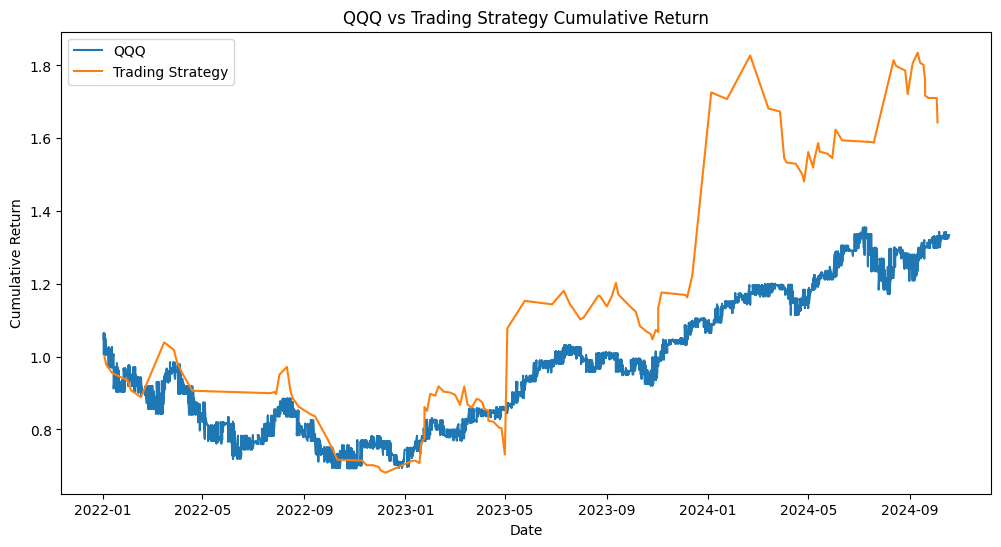

In [157]:
# Plot the QQQ return and compare with the trading strategy
import matplotlib.pyplot as plt

def plot_strategy_vs_qqq(start_date, end_date):
    # Load the QQQ data
    qqq_data = pd.DataFrame(list(mongo_client[mongo_config['db_name']][mongo_config['process_collection_name']].find({'symbol': 'QQQ'}, {'_id': 0})))
    qqq_data['date'] = pd.to_datetime(qqq_data['date'])
    qqq_data = qqq_data[(qqq_data['date'] >= start_date) & (qqq_data['date'] <= end_date)]
    qqq_data = qqq_data.sort_values(by='date')

    # Calculate the return
    qqq_data['return'] = qqq_data['close'].pct_change()
    qqq_data['cumulative_return'] = (1 + qqq_data['return']).cumprod()

    # Calculate the trading strategy Trades History
    trading_strategy = DailyTradingStrategy(data_collection=mongo_client[mongo_config['db_name']][mongo_config['process_collection_name']],
                                            alert_collection=mongo_client[mongo_config['db_name']][mongo_config['alert_collection_name']['long_term']],
                                            stock_candidates=stock_of_the_day, aggressive_split=1.0,

                                            start_date=start_date, end_date=end_date)

    trading_strategy.run_trading_strategy()
    trades_history = trading_strategy.get_trades()
    trades_history['date'] = pd.to_datetime(trades_history['Entry_date']).dt.date
    trades_history = trades_history.sort_values(by='date')

    # Calculate the return
    trades_history['return'] = trades_history['profit/loss'].str.replace('%', '').astype(float) / 100
    trades_history['cumulative_return'] = (1 + trades_history['return']).cumprod()

    # Plot the cumulative return
    plt.figure(figsize=(12, 6))
    plt.plot(qqq_data['date'], qqq_data['cumulative_return'], label='QQQ')
    plt.plot(trades_history['date'], trades_history['cumulative_return'], label='Trading Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('QQQ vs Trading Strategy Cumulative Return')
    plt.legend()
    plt.show()

# Example usage
plot_strategy_vs_qqq('2022-01-01', '2024-10-18')

